<a href="https://colab.research.google.com/github/guillaumetougas/sbl_hyperspectral_ai/blob/main/02_scripts/sbl_hyperspec_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1D-CNN model from hyperspectral data


In [29]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torchvision as tv
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchaudio as ta
!pip install rasterio
import rasterio as rio

###Load preprocessed HS data

In [30]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import random
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [46]:
#Load HS data with geopandas
smoothed_data=gpd.read_file("/content/drive/MyDrive/2024-Tougas-PhD/Data_SBL_HS_AI/sbl_smoothed_spectra.gpkg")

#isolate spectral data and prepare with rasterio
spectral_data_labeled = smoothed_data.drop(columns=['geometry']).values
#print(np.shape(spectral_data_labeled))
#print(spectral_data_labeled[:5])

spectral_data = spectral_data_labeled[:, 1:243]
print(spectral_data[:,241])

[0.06830659106593368 0.05044518727648489 0.0711628405797041 ...
 0.0002695426312816876 0.0002724091850176913 0.0]


### Create the 1D-CNN model

In [51]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Example hyperspectral data (N samples, C spectral bands)
# Replace this with your actual data
N, C = 21696, 242  # Example: 21696 pixels, 242 bands
#X = spectral_data
#Y = labels

# Normalization (recommended for pretrained generic models like 1D CNN)
spectral_data = (spectral_data - np.min(spectral_data)) / (np.max(spectral_data) - np.min(spectral_data))

# Ensure spectral_data has a numeric dtype before converting to tensor
spectral_data = spectral_data.astype(np.float32)  # or np.float64

labels = smoothed_data['Label']
print(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spectral_data, labels, test_size=0.2, random_state=42)

# 1. Create train/val indices instead of directly splitting
dataset_size = len(spectral_data)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))  # 20% for validation
np.random.shuffle(indices)  # Shuffle indices randomly
train_indices, val_indices = indices[split:], indices[:split]

# 2. Separate data using the indices
X_train, X_val = spectral_data[train_indices], spectral_data[val_indices]
y_train, y_val = labels.iloc[train_indices], labels.iloc[val_indices]

# 3. Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# 4. Create PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32)
y_train, y_val = torch.tensor(y_train_encoded, dtype=torch.long), torch.tensor(y_val_encoded, dtype=torch.long)

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)  # If using CUDA
torch.cuda.manual_seed_all(42)  # If using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define a 1D CNN for hyperspectral data classification
class HyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(HyperspectralCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        fc1_input_size = 128 * input_channels #output size of conv2 x number of bands
        self.fc1 = nn.Linear(fc1_input_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        # x = self.pool(x)

        # Check if x has 3 dimensions before accessing x.size(2)
        #if x.dim() == 3:
        fc1_input_size = x.size(1) * x.size(2)
        #else:
            # If x has only 2 dimensions, calculate fc1_input_size accordingly
        #    fc1_input_size = x.size(1)

        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Adjust fc1 input size to match the actual flattened size
        self.fc1 = nn.Linear(fc1_input_size, 256)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

0         BEPA
1         ACRU
2        Picea
3         ACSA
4         ABBA
         ...  
21691     THOC
21692     THOC
21693    Picea
21694    Picea
21695     Mort
Name: Label, Length: 21696, dtype: object


###Model parameters and optimizer and loss function set up





In [52]:
# Model parameters
input_channels = C
num_classes = len(torch.unique(y_train))  # Number of unique labels
# Reshape for 1D CNN - Assuming spectral bands are in rows
# Transpose to have samples in rows and spectral bands in columns
X_train = X_train.T
X_val = X_val.T

# Initialize the model, loss function, and optimizer
model = HyperspectralCNN(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


###Train the model

In [89]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)  # If using CUDA
torch.cuda.manual_seed_all(42)  # If using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Training loop
num_epochs = 100  # You can adjust this
for epoch in range(num_epochs):

 # Since your sequence length is 1 (each sample is a spectral signature),
  # you need to add a dimension:
  X_train_reshaped = X_train.T[:, :, None] #add extra dimension to have a 3D tensor

  # Create a DataLoader to handle batching
  train_dataset = torch.utils.data.TensorDataset(X_train_reshaped, y_train)  # Transpose X_train back

  #Define batch size
  batch_size = 32

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  for batch_idx, (data, target) in enumerate(train_loader):
    # Forward pass
    outputs = model(data)
    loss = criterion(outputs, target)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print loss every 100 iterations
    if (batch_idx + 1) % 500 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{batch_idx+1}], Loss: {loss.item():.4f}')

Epoch [1/100], Iteration [500], Loss: 1.7613
Epoch [2/100], Iteration [500], Loss: 1.5496
Epoch [3/100], Iteration [500], Loss: 2.2639
Epoch [4/100], Iteration [500], Loss: 1.7006
Epoch [5/100], Iteration [500], Loss: 1.9387
Epoch [6/100], Iteration [500], Loss: 1.9269
Epoch [7/100], Iteration [500], Loss: 1.7382
Epoch [8/100], Iteration [500], Loss: 1.7761
Epoch [9/100], Iteration [500], Loss: 1.5500
Epoch [10/100], Iteration [500], Loss: 1.6109
Epoch [11/100], Iteration [500], Loss: 1.7221
Epoch [12/100], Iteration [500], Loss: 1.7415
Epoch [13/100], Iteration [500], Loss: 1.5926
Epoch [14/100], Iteration [500], Loss: 2.1636
Epoch [15/100], Iteration [500], Loss: 1.6461
Epoch [16/100], Iteration [500], Loss: 1.9022
Epoch [17/100], Iteration [500], Loss: 1.7515
Epoch [18/100], Iteration [500], Loss: 2.0996
Epoch [19/100], Iteration [500], Loss: 1.5835
Epoch [20/100], Iteration [500], Loss: 1.7777
Epoch [21/100], Iteration [500], Loss: 1.6288
Epoch [22/100], Iteration [500], Loss: 1.85

###Evaluate the model

In [90]:
# Evaluate the model on a test dataset
model.eval()
with torch.no_grad():
   # Reshape the validation data to add an extra dimension for sequence length
    X_val_reshaped = X_val.T[:, :, None]

    # Create a DataLoader for the validation set
    val_dataset = torch.utils.data.TensorDataset(X_val_reshaped, y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for evaluation

    total_correct = 0
    total_samples = 0

    for data, target in val_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)  # Get predicted class labels
        total_correct += (predicted == target).sum().item()
        total_samples += target.size(0)

    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.4307


###Visualize model performance

In [91]:
!pip install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

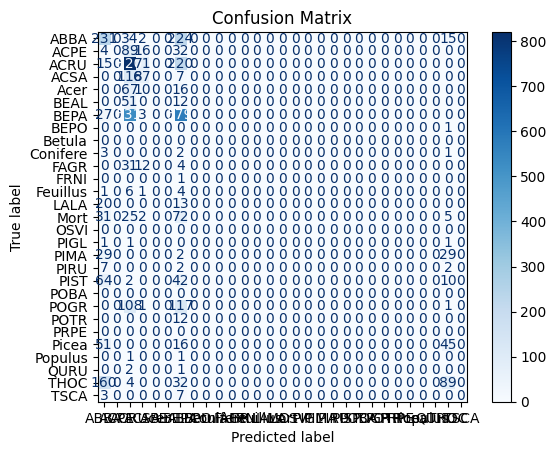

[231   0 820  67   0   0 579   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  89   0]


In [92]:
# Get predictions for the entire validation set
with torch.no_grad():
    X_val_reshaped = X_val.T[:, :, None]  # Reshape validation data
    outputs = model(X_val_reshaped)
    _, predicted = torch.max(outputs, 1)  # Get predicted class labels

# Calculate confusion matrix
cm = confusion_matrix(y_val.cpu().numpy(), predicted.cpu().numpy(),labels=np.arange(len(label_encoder.classes_)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(np.diagonal(cm)) #Only ABBA, ACRU and THOC present TP

In [93]:
# Assuming y_true and y_pred are your true and predicted labels
with torch.no_grad():
    X_val_reshaped = X_val.T[:, :, None]  # Reshape validation data
    outputs = model(X_val_reshaped)
    _, predicted = torch.max(outputs, 1)  # Get predicted class labels


# Note: y_val is already on the CPU since it was used in the validation loop
f1 = f1_score(y_val, predicted.cpu(), average='weighted')  # Use 'weighted' for multi-class
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.3735


In [94]:
from sklearn.metrics import classification_report

report = classification_report(
        y_val,
        predicted.cpu(),
        target_names=label_encoder.classes_,
        labels=np.arange(len(label_encoder.classes_))  # All classes in the encoder
  )
print(report)

              precision    recall  f1-score   support

        ABBA       0.36      0.40      0.38       506
        ACPE       0.00      0.00      0.00       141
        ACRU       0.47      0.76      0.58      1126
        ACSA       0.53      0.20      0.29       192
        Acer       0.00      0.00      0.00        93
        BEAL       0.00      0.00      0.00        63
        BEPA       0.50      0.55      0.52      1140
        BEPO       0.00      0.00      0.00         1
      Betula       0.00      0.00      0.00         0
    Conifere       0.00      0.00      0.00         6
        FAGR       0.00      0.00      0.00        47
        FRNI       0.00      0.00      0.00         1
    Feuillus       0.00      0.00      0.00        12
        LALA       0.00      0.00      0.00        33
        Mort       0.00      0.00      0.00       135
        OSVI       0.00      0.00      0.00         0
        PIGL       0.00      0.00      0.00         3
        PIMA       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me